# CPU Scheduling Algorithm
ชวศิษฐ์ เต็งไตรรันต์ (580610631)

## Load Library

In [1]:
from numpy.random import shuffle, uniform
import numpy as np
from copy import copy
import pandas as pd

## Concept & Code
### 1. First Come First Served

In [2]:
def first_come_first_served(jobs=None):
    if jobs is None:
        jobs = []

    jobs = copy(jobs)
    size = len(jobs)
    wait_time = 0.0
    current_time = 0.0

    while len(jobs):
        job_time = jobs.pop(0)
        wait_time += current_time
        current_time += job_time

    return wait_time / size

### 2. Shortest Job First

In [3]:
def shortest_job_first(jobs=None):
    if jobs is None:
        jobs = []

    jobs = copy(jobs)
    jobs.sort()
    size = len(jobs)
    wait_time = 0.0
    current_time = 0.0

    while len(jobs):
        job_time = jobs.pop(0)
        wait_time += current_time
        current_time += job_time

    return wait_time / size

### 3. Round Robin
The default context switch time is 3 microseconds. In this work time unit is miliseconds so context_switch_time is 3e-3

[REFERENCE](http://blog.tsunanet.net/2010/11/how-long-does-it-take-to-make-context.html)

In [4]:
def round_robin(jobs=None, quantum=3, context_switch_time=3e-3):
    if jobs is None:
        jobs = []

    jobs = copy(jobs)
    jobs.sort()
    size = len(jobs)
    wait_time = 0.0
    current_time = 0.0

    last_process_time = [0 for i in range(len(jobs))]
    while len(jobs):
        ended_job_indexs = []
        for i in range(len(jobs)):
            job_time = jobs[i]
            if job_time <= quantum:
                ended_job_indexs.append(i)
                wait_time += current_time - last_process_time[i]
                current_time += job_time
            else:
                current_time += quantum
                jobs[i] -= quantum
                last_process_time[i] = current_time
            current_time += context_switch_time

        ended_job_indexs.sort(reverse=True)
        for i in ended_job_indexs:
            jobs.pop(i)

    return wait_time / size

## Dataset
### Generate Code

In [5]:
def generate(n=60, distributions=None):
    """Return a generated list of number by given list of range and distribution tuple
        eg. spec = [(2, 8, 0.7), (20, 30, 0.2), (35, 40, 0.1)]
    """
    if distributions is None:
        distributions = [(2, 8, 0.7), (20, 30, 0.2), (35, 40, 0.1)]

    if n <= 0:
        raise Exception("n must greater than 0")

    if sum(map(lambda x: x[2], distributions)) - 1.0 > 1e-7:
        raise Exception("summation of probability must equal to 1")

    ret = []

    for distribution in distributions:
        size = int(distribution[2] * n)
        ret.extend(map(int, uniform(distribution[0], distribution[1], size)))

    shuffle(ret)

    return ret

## Create Dataset


| Type | 2-8 ms | 20-30 ms | 40-50 ms |
| :-: |:-:|:-:|:-:|
| A | 70% | 20% | 10% |
| B | 30% | 40% | 30% |
| C | 10% | 20% | 70% |

Each dataset type has 100 processes.

In [6]:
datasets = {'A': generate(100, [(2, 8, 0.7), (20, 30, 0.2), (40, 50, 0.1)]),
            'B': generate(100, [(2, 8, 0.3), (20, 30, 0.4), (40, 50, 0.3)]),
            'C': generate(100, [(2, 8, 0.1), (20, 30, 0.2), (40, 50, 0.7)])}

algorithms = [first_come_first_served, shortest_job_first]

results = {}
for algorithm in algorithms:
    name = algorithm.__name__
    wait_times = {}
    for key, dataset in datasets.iteritems():
        wait_times[key] = algorithm(dataset)
    results[name] = wait_times

for quantum in range(1, 19, 5):
    name = round_robin.__name__ + "_q" + str(quantum)
    wait_times = {}
    for key, dataset in datasets.iteritems():
        wait_times[key] = round_robin(dataset, quantum)
    results[name] = wait_times
    
results = pd.DataFrame.from_dict(results)
    
results

,first_come_first_served,round_robin_q1,round_robin_q11,round_robin_q16,round_robin_q6,shortest_job_first
A,616.04,214.46446,333.24691,370.40862,160.48637,286.55
B,1291.38,183.71248,969.82847,1215.91218,325.24516,765.74
C,1815.62,172.26825,1412.22375,1644.84469,571.70497,1448.59


## Result

<IPython.core.display.Javascript object>


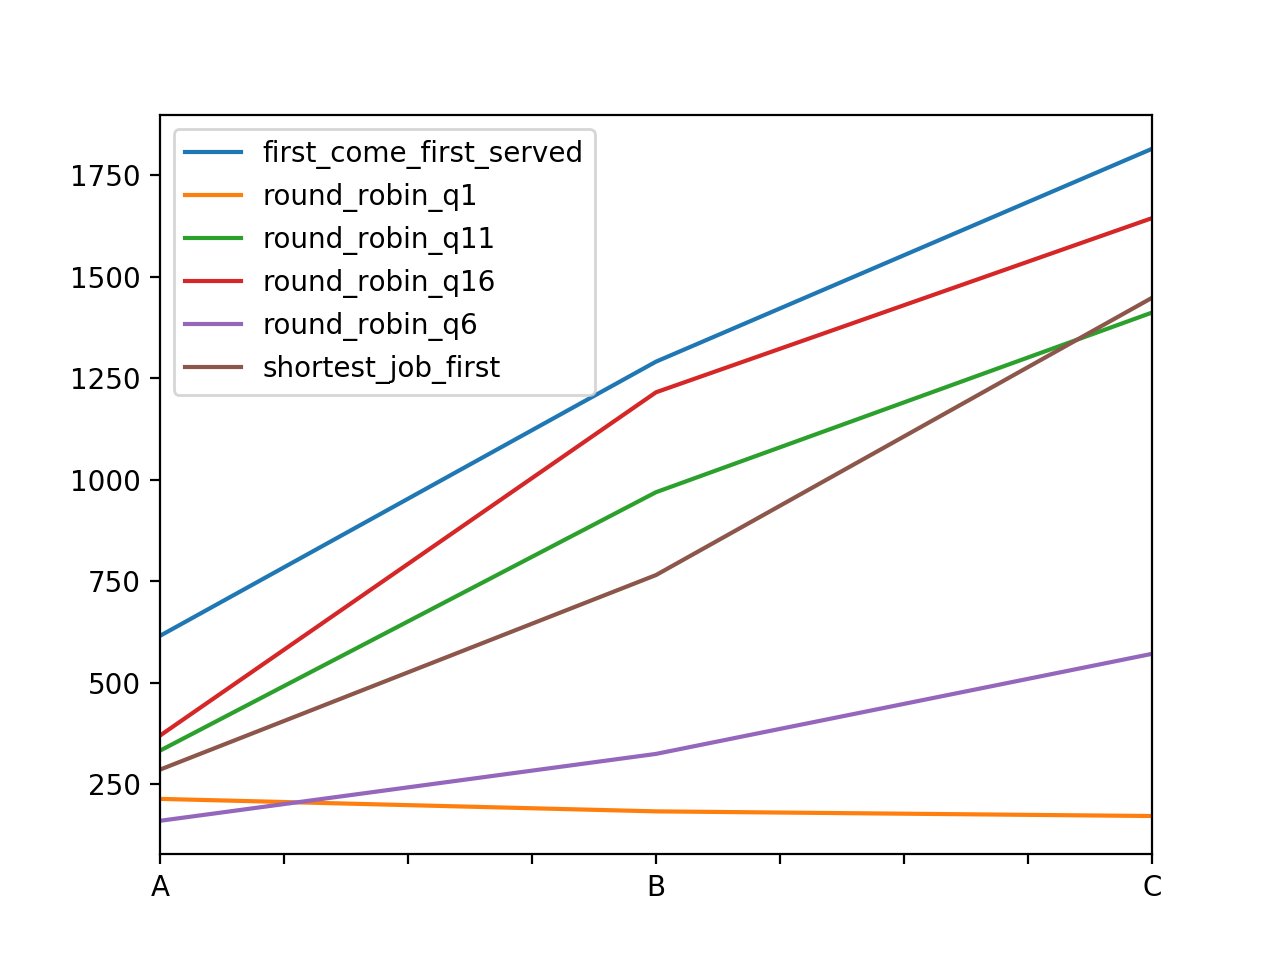

In [7]:
%matplotlib notebook
results.plot()

## Conclusion
จากผลการทดลองวิธี first come first served ได้เวลารอเฉลี่ยมากที่สุดในทุก dataset รองลงมาคือวิธี shortest job first และวิธี round robin มีได้เวลารอเฉลี่ยน้อยสุด

จากการทดลองเปลี่ยน quantum ของ round robin พบว่าจาก dataset ที่กำหนด เมื่อเพิ่ม quantum ส่งผลให้เวลารอเฉลี่ยสูงขึ้น(แปรผันตาม quantum) โดย quantum ที่ 16 มีเวลารอเฉลี่ยสูงที่สุด

จากข้อสังเกต quantum มีค่าสูงเมื่อเทียบกับ job time ใน dataset ดังนั้น context switch time จึงยังไม่ส่งผลชัดเจนในทุก dataset ที่ทดสอบ

สรุปผลการทดลองวิธีที่ดีที่สุดที่ให้เวลารอเฉลี่ยน้อยที่สุดคือ Round Robin
